In [4]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [5]:

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [6]:

BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
#@title Visualization Utilities[RUN ME]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [8]:
import tensorflow as tf

(training_images,training_labels),(validation_images,validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


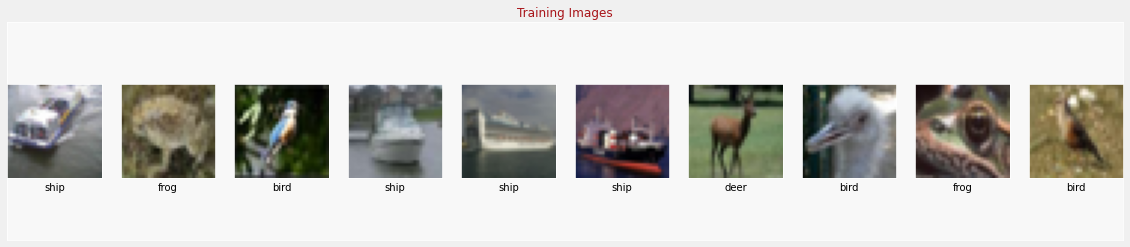

In [9]:
display_images(training_images, training_labels, training_labels, "Training Images")

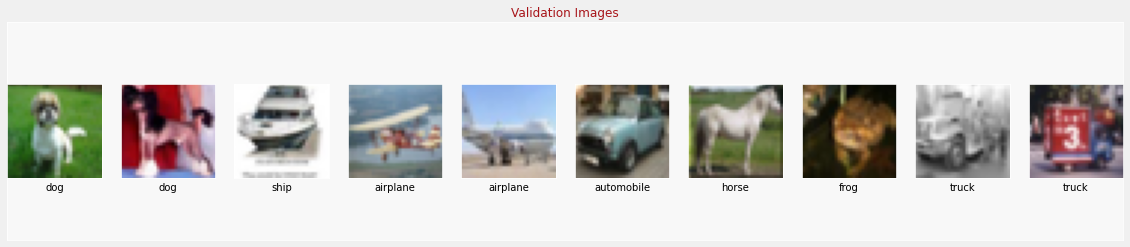

In [10]:
display_images(validation_images, validation_labels, validation_labels, "Validation Images")

In [11]:
def preprocess_input_image(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [12]:
train_X = preprocess_input_image(training_images)
valid_X = preprocess_input_image(validation_images)

In [13]:
def feature_extractor(inputs):
  return tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                 include_top=False,
                                                 weights='imagenet')(inputs)

In [14]:
from tensorflow.keras.layers import Flatten, Dense

def classifier(inputs):
  x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
  x = Flatten()(x)
  x = Dense(1024,activation='relu')(x)
  x = Dense(512,activation='relu')(x)
  x = Dense(10,activation='softmax',name='classification')(x)
  return x



In [15]:

def final_model(inputs):
  x = tf.keras.layers.UpSampling2D(size=(7,7))(inputs) #224/32 = 7
  x = feature_extractor(x)
  x = classifier(x)
  return x


In [16]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def model_compile():
  inputs = Input(shape=(32,32,3))
  classification_output = final_model(inputs)
  model = Model(inputs=inputs,outputs=classification_output)
  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [17]:
model = model_compile()
model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

In [18]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/4
782/782 [==============================] - 560s 669ms/step - loss: 0.4042 - accuracy: 0.8683 - val_loss: 0.3250 - val_accuracy: 0.8943
Epoch 2/4
782/782 [==============================] - 511s 653ms/step - loss: 0.1027 - accuracy: 0.9662 - val_loss: 0.1578 - val_accuracy: 0.9495
Epoch 3/4
782/782 [==============================] - 510s 653ms/step - loss: 0.0338 - accuracy: 0.9898 - val_loss: 0.1588 - val_accuracy: 0.9511
Epoch 4/4
782/782 [==============================] - 509s 651ms/step - loss: 0.0149 - accuracy: 0.9965 - val_loss: 0.1828 - val_accuracy: 0.9492


In [19]:

loss,accuracy = model.evaluate(valid_X,validation_labels,batch_size=64)

157/157 [==============================] - 30s 192ms/step - loss: 0.1828 - accuracy: 0.9492


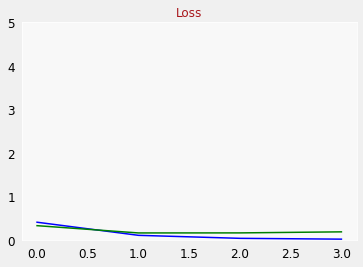

In [20]:
plot_metrics("loss", "Loss")

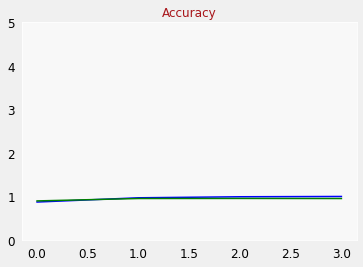

In [21]:
plot_metrics("accuracy", "Accuracy")

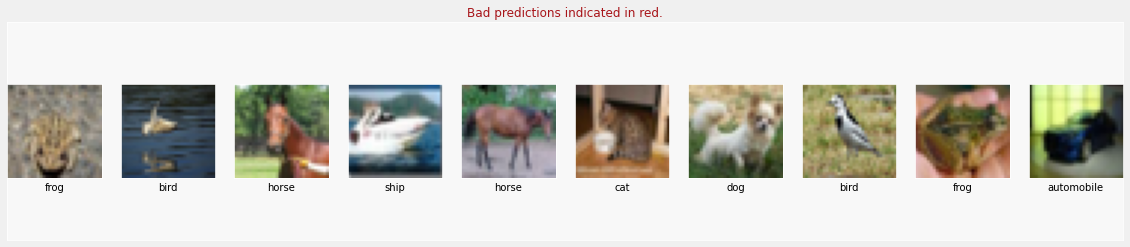

In [22]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")